# Late Fusion: Audio Modeling

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/audio/'
output_path = '../out/audio/'
# Global configuration path
glob_conf_path = '../../../config/global_config.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load data

In [4]:
train_egemaps_df = pd.read_csv(os.path.join(input_path, 'egemaps', 'audio_data_egemaps_late_fusion_train.csv'))
test_egemaps_df = pd.read_csv(os.path.join(input_path, 'egemaps', 'audio_data_egemaps_late_fusion_test.csv'))

train_gemaps_df = pd.read_csv(os.path.join(input_path, 'gemaps', 'audio_data_gemaps_late_fusion_train.csv'))
test_gemaps_df = pd.read_csv(os.path.join(input_path, 'gemaps', 'audio_data_gemaps_late_fusion_test.csv'))

In [5]:
train_egemaps_df.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,target
0,32.25328,0.248346,28.48594,32.81652,38.77012,10.284180,54.80582,29.32340,65.10525,7.753541,...,-0.003858,0.222840,2.312139,1.759531,0.303333,0.502615,0.245000,0.086362,-25.07678,9
1,35.31089,0.169806,31.82989,36.88577,39.76237,7.932484,91.53120,30.14883,35.22653,22.054080,...,-0.001485,0.157199,3.000000,1.546392,0.536667,0.244586,0.130000,0.010000,-24.96124,6
2,15.00466,0.197219,13.08473,14.17712,15.54830,2.463572,141.89270,58.63279,65.23180,94.959310,...,-0.008247,0.569787,5.154639,6.417112,0.082500,0.057609,0.084286,0.039949,-30.61435,17
3,27.19199,0.203668,22.02517,28.73136,31.81585,9.790684,227.96290,207.72190,168.91290,140.438400,...,-0.007626,0.676697,7.142857,3.731344,0.218000,0.165336,0.050000,0.024495,-23.59847,1
4,31.61772,0.191328,23.65003,34.24127,35.96895,12.318920,217.99010,174.03710,72.39302,45.165160,...,-0.008659,0.161784,4.232804,1.630435,0.423333,0.247835,0.250000,0.210000,-22.89440,8


## Normalization

In [6]:
from sklearn import preprocessing

# eGeMAPS dataset normalization
X = train_egemaps_df.drop(columns=['target'])                                   # Get features from dataset
min_max_scaler_egemaps = preprocessing.MinMaxScaler()                           # eGeMAPS min max scaler
X_scaled = min_max_scaler_egemaps.fit_transform(X)                              # Fit and transform features
X_scaled_egemaps_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())  # Create a dataframe from normalized features
X_scaled_egemaps_df.head()                                                      # Check dataframe
y_egemaps_df = train_egemaps_df['target']                                       # Get target values

# GeMAPS dataset normalization
X = train_gemaps_df.drop(columns=['target'])                                    # Get features from dataset
min_max_scaler_gemaps = preprocessing.MinMaxScaler()                            # GeMAPS min max scaler
X_scaled = min_max_scaler_gemaps.fit_transform(X)                               # Fit and transform features
X_scaled_gemaps_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())   # Create a dataframe from normalized features
X_scaled_gemaps_df.head()                                                       # Check dataframe
y_gemaps_df = train_gemaps_df['target']                                         # Get target values

# Save min_max_scaler
file_path = os.path.join(input_path,'egemaps','min_max_scaler_egemaps_audio.sav')
pickle.dump(min_max_scaler_egemaps, open(file_path, 'wb'))
#print(min_max_scaler_egemaps.data_range_)

## Other functions

In [14]:
from sklearn.metrics import confusion_matrix

def plot_save_conf_matrix(X_test, y_test, clf, title, file_name, report=False):
    scores = clf.predict_proba(X_test_db)           # Predict probabilities
    AUC_test = roc_auc_score(y_true=y_test_db,
                             y_score=scores,
                             average='macro',
                             multi_class='ovo')  # Get AUC score
    print('AUC (test):', AUC_test)
    
    y_pred = clf.predict(X_test_db)
    conf_mat = confusion_matrix(y_test_db, y_pred, normalize='true')
    df_cm = pd.DataFrame(conf_mat, list(emotion_id_to_emotion_num.keys()), list(emotion_id_to_emotion_num.keys()))
    
    fig=plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')
    plt.show()
    

## Elastic Net SGD Classifier

In [ ]:
def modeling_audio(X, y, skf, parameters, param_set='egemaps', clf_type='elastic_net'):
    # Initialize some variables to store results
    results = []
    AUC_avg_best_model = 0
    params_best_model = None
    for i in tqdm(range(len(parameters))):
        AUC_avg = 0  # Initialize average AUC
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
            
            
            if clf_type == 'elastic_net':
                # Compute class weight
                class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
                class_weight = {n:class_weight[n] for n in range(0,18)}
                
                # Create new classifier
                clf = SGDClassifier(penalty      = 'elasticnet',
                                    alpha        = parameters[i][0],
                                    loss         = parameters[i][1],
                                    l1_ratio     = parameters[i][2],
                                    random_state = seed,
                                    n_jobs       = -1,
                                    class_weight = class_weight
                                   )
            elif clf_type == 'knn':
                break
            elif clf_type == 'tree':
                break
            elif clf_type == 'rf':
                break
            
            clf.fit(X_train,y_train) # Fit classifier (train dataset)
            
            
            # Compute results (validation dataset)
            scores = clf.predict_proba(X_val)           # Predict probabilities
            AUC_tmp = roc_auc_score(y_true=y_val,
                                    y_score=scores,
                                    average='macro',
                                    multi_class='ovo')  # Get AUC score
            AUC_avg += AUC_tmp                          # Add new AUC
        
        AUC_avg /= n_folds                              # Get average AUC for alpha = a
        
        # Add new results to the results list
        results.append(['elasticnet',                   # Penalty
                        parameters[i][0],               # Alpha
                        parameters[i][1],               # Loss
                        parameters[i][2],               # L1_ratio
                        AUC_avg
                       ])
        
        # Check if current average AUC is better than the stored
        if AUC_avg > AUC_avg_best_model:
            AUC_avg_best_model = AUC_avg                # Update best average AUC
            params_best_model = parameters[i]           # Update best model parameters
    
            
    # Store the results in a DataFrame and then save them as csv
    results_df = pd.DataFrame(data=results, columns=['Penalty','Alpha','Loss','L1_ratio','AUC_avg'])
    results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_folds)+'_fold_cv_egemaps_audio.csv'), index=None, header=True)
    
    
    # Train model with the parameters of the best model  (using full training set)    
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_egemaps_df), y=y_egemaps_df)
    class_weight = {n:class_weight[n] for n in range(0,18)}
    best_model = SGDClassifier(penalty      = 'elasticnet',
                               alpha        = params_best_model[0],
                               loss         = params_best_model[1],
                               l1_ratio     = params_best_model[2],
                               random_state = seed,
                               n_jobs       = -1,
                               class_weight = class_weight
                              )
    best_model.fit(X_scaled_egemaps_df, y_egemaps_df)    # Fit model (full train dataset)

### eGeMAPS

In [14]:
from sklearn.linear_model import SGDClassifier


# Create new variables to split the train dataset into k folds
X = X_scaled_egemaps_df
y = y_egemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
alpha_values    = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 1]
loss_values     = ['log', 'modified_huber']
l1_ratio_values = np.arange(0.05, 1.05, 0.05).tolist()
parameters      = [(alpha,loss,l1_ratio)  
                   for alpha in alpha_values
                   for loss in loss_values
                   for l1_ratio in l1_ratio_values
                  ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0  # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Create new classifier and fit it (train dataset)
        clf = SGDClassifier(penalty      = 'elasticnet',
                            alpha        = parameters[i][0],
                            loss         = parameters[i][1],
                            l1_ratio     = parameters[i][2],
                            random_state = seed,
                            n_jobs       = -1,
                            class_weight = class_weight
                           )
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)           # Predict probabilities
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')  # Get AUC score
        AUC_avg += AUC_tmp                          # Add new AUC
    
    AUC_avg /= n_folds                              # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append(['elasticnet',                   # Penalty
                    parameters[i][0],               # Alpha
                    parameters[i][1],               # Loss
                    parameters[i][2],               # L1_ratio
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['Penalty','Alpha','Loss','L1_ratio','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_folds)+'_fold_cv_egemaps_audio.csv'), index=None, header=True)


# Train model with the parameters of the best model  (using full training set)    
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_egemaps_df), y=y_egemaps_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = SGDClassifier(penalty      = 'elasticnet',
                           alpha        = params_best_model[0],
                           loss         = params_best_model[1],
                           l1_ratio     = params_best_model[2],
                           random_state = seed,
                           n_jobs       = -1,
                           class_weight = class_weight
                          )
best_model.fit(X_scaled_egemaps_df, y_egemaps_df)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_egemaps_audio.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 400/400 [12:03<00:00,  1.81s/it]


SGDClassifier(alpha=0.001, average=False,
              class_weight={0: 2.2801932367149758, 1: 0.7712418300653595,
                            2: 2.2801932367149758, 3: 0.7827529021558872,
                            4: 2.2801932367149758, 5: 0.7827529021558872,
                            6: 0.7827529021558872, 7: 2.2801932367149758,
                            8: 0.7827529021558872, 9: 0.7827529021558872,
                            10: 0.7712418300653595, 11: 0.7827529021558872,
                            12: 2.2801932367149758, 13: 0.7827529021558872,
                            14: 0.7827529021558872, 15: 0.7827529021558872,
                            16: 2.2801932367149758, 17: 0.7827529021558872},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.05, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=24, shuffle=True

In [15]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,Penalty,Alpha,Loss,L1_ratio,AUC_avg
120,elasticnet,0.0010,log,0.05,0.839152
122,elasticnet,0.0010,log,0.15,0.838973
121,elasticnet,0.0010,log,0.10,0.838935
123,elasticnet,0.0010,log,0.20,0.838914
83,elasticnet,0.0001,log,0.20,0.837647


AUC (test): 0.8504625761525428


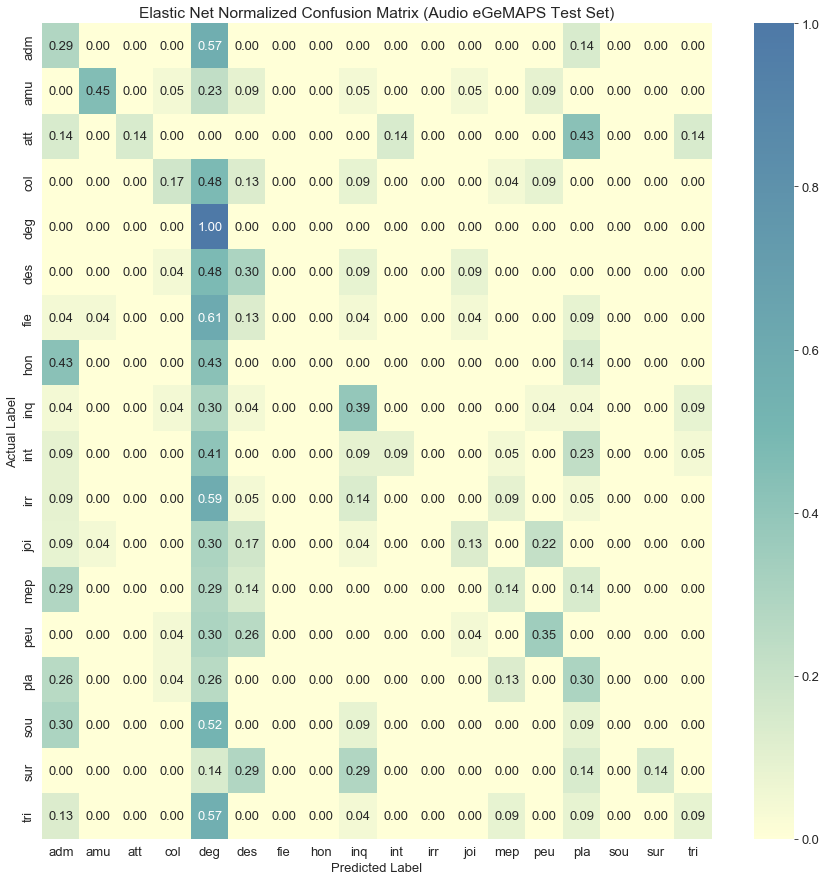

In [15]:
X = test_egemaps_df.drop(columns=['target'])
y = test_egemaps_df['target']

# Get test features and labels from the dataset
X_array =  min_max_scaler_egemaps.transform(X)
X_test_db = pd.DataFrame(data=X_array, columns=X.columns.to_list())
y_test_db = y

# load the model from disk
file_path = os.path.join(output_path,'models','mod_elastic_net_egemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Elastic Net Normalized Confusion Matrix (Audio eGeMAPS Test Set)',
                      file_name = 'conf_mat_elastic_net_egemaps_audio.svg'
                     )

### GeMAPS

In [10]:
from sklearn.linear_model import SGDClassifier


# Create new variables to split the train dataset into k folds
X = X_scaled_gemaps_df
y = y_gemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
alpha_values    = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 1]
loss_values     = ['log', 'modified_huber']
l1_ratio_values = np.arange(0.05, 1.05, 0.05).tolist()
parameters      = [(alpha,loss,l1_ratio)  
                   for alpha in alpha_values
                   for loss in loss_values
                   for l1_ratio in l1_ratio_values
                  ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0  # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Create new classifier and fit it (train dataset)
        clf = SGDClassifier(penalty      = 'elasticnet',
                            alpha        = parameters[i][0],
                            loss         = parameters[i][1],
                            l1_ratio     = parameters[i][2],
                            random_state = seed,
                            n_jobs       = -1,
                            class_weight = class_weight
                           )
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)           # Predict probabilities
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')  # Get AUC score
        AUC_avg += AUC_tmp                          # Add new AUC
    
    AUC_avg /= n_folds                              # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append(['elasticnet',                   # Penalty
                    parameters[i][0],               # Alpha
                    parameters[i][1],               # Loss
                    parameters[i][2],               # L1_ratio
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['Penalty','Alpha','Loss','L1_ratio','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_folds)+'_fold_cv_gemaps_audio.csv'), index=None, header=True)


# Train model with the parameters of the best model  (using full training set)    
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_gemaps_df), y=y_gemaps_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = SGDClassifier(penalty      = 'elasticnet',
                           alpha        = params_best_model[0],
                           loss         = params_best_model[1],
                           l1_ratio     = params_best_model[2],
                           random_state = seed,
                           n_jobs       = -1,
                           class_weight = class_weight
                          )
best_model.fit(X_scaled_gemaps_df, y_gemaps_df)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_gemaps_audio.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 400/400 [10:12<00:00,  1.53s/it]

SGDClassifier(alpha=0.001, average=False,
              class_weight={0: 2.2801932367149758, 1: 0.7712418300653595,
                            2: 2.2801932367149758, 3: 0.7827529021558872,
                            4: 2.2801932367149758, 5: 0.7827529021558872,
                            6: 0.7827529021558872, 7: 2.2801932367149758,
                            8: 0.7827529021558872, 9: 0.7827529021558872,
                            10: 0.7712418300653595, 11: 0.7827529021558872,
                            12: 2.2801932367149758, 13: 0.7827529021558872,
                            14: 0.7827529021558872, 15: 0.7827529021558872,
                            16: 2.2801932367149758, 17: 0.7827529021558872},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.1, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=24, shuffle=True,

In [11]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,Penalty,Alpha,Loss,L1_ratio,AUC_avg
121,elasticnet,0.001,log,0.10,0.823730
120,elasticnet,0.001,log,0.05,0.823581
124,elasticnet,0.001,log,0.25,0.823560
123,elasticnet,0.001,log,0.20,0.823316
122,elasticnet,0.001,log,0.15,0.823301


AUC (test): 0.8339163278094858


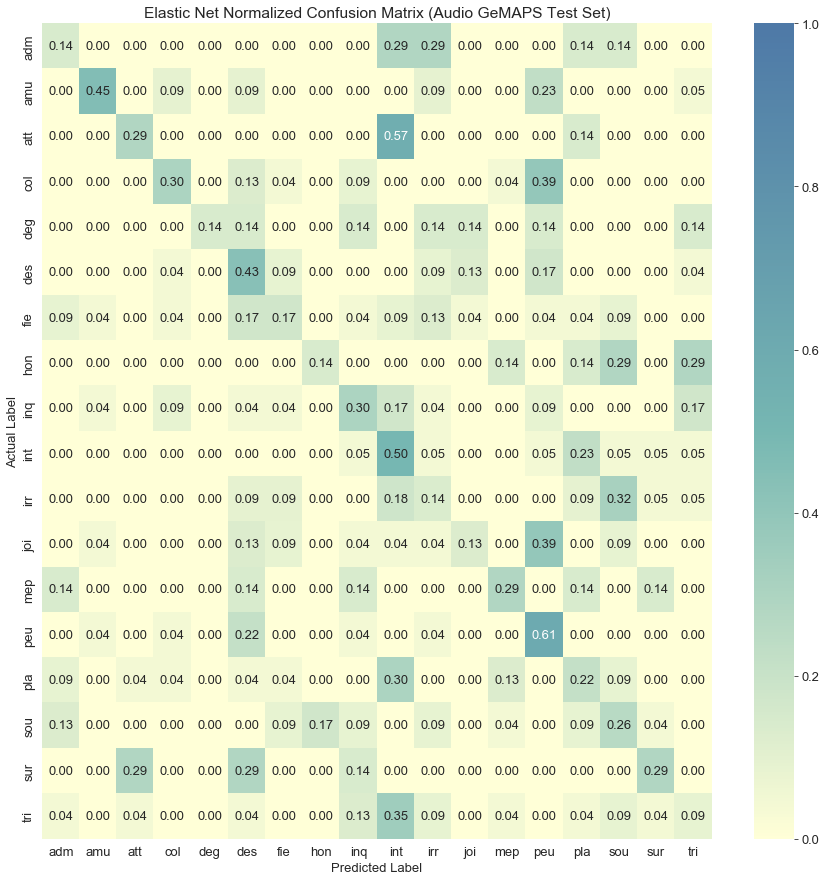

In [17]:
from sklearn.metrics import confusion_matrix


X = test_gemaps_df.drop(columns=['target'])
y = test_gemaps_df['target']

# Get test features and labels from the dataset
X_array =  min_max_scaler_gemaps.transform(X)
X_test_db = pd.DataFrame(data=X_array, columns=X.columns.to_list())
y_test_db = y

# load the model from disk
file_path = os.path.join(output_path,'models','mod_elastic_net_gemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Elastic Net Normalized Confusion Matrix (Audio GeMAPS Test Set)',
                      file_name = 'conf_mat_elastic_net_gemaps_audio.svg'
                     )

## kNN Classifier

### eGeMAPS

In [13]:
from sklearn.neighbors import KNeighborsClassifier


# Create new variables to split the train dataset into k folds
X = X_scaled_egemaps_df
y = y_egemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
n_neigh_values   = np.arange(50, 405, 5).tolist()
leaf_size_values = np.arange(30, 310, 5).tolist()
weights_values   = ['uniform', 'distance']
parameters = [(n_neigh,leaf_size,weights)  
              for n_neigh in n_neigh_values
              for leaf_size in leaf_size_values
              for weights in weights_values
             ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y): 
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Create a new classifier and fit it (train dataset)
        clf = KNeighborsClassifier(n_neighbors  = parameters[i][0],
                                   leaf_size    = parameters[i][1],
                                   weights      = parameters[i][2],
                                   n_jobs       = -1
                                  )
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)             # Predict probability
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC score
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_neighbors
                    parameters[i][1],                 # leaf_size
                    parameters[i][2],                 # weights
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                  # Update best average AUC
        params_best_model = parameters[i]             # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['k_neighbors','leaf_size','weights','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_folds)+'_fold_cv_egemaps_audio.csv') , index=None, header=True)



# Train model with the parameters of the best model  (using full training set)    
best_model = KNeighborsClassifier(n_neighbors  = params_best_model[0],
                                  leaf_size    = params_best_model[1],
                                  weights      = params_best_model[2],
                                  n_jobs       = -1
                                 )
best_model.fit(X_scaled_egemaps_df, y_egemaps_df)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_egemaps_audio.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 7952/7952 [4:29:40<00:00,  2.03s/it]  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=115, p=2,
                     weights='distance')


In [14]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,k_neighbors,leaf_size,weights,AUC_avg
1457,115,30,distance,0.80323
1497,115,130,distance,0.80323
1517,115,180,distance,0.80323
1461,115,40,distance,0.80323
1515,115,175,distance,0.80323


AUC (test): 0.8264307105460255


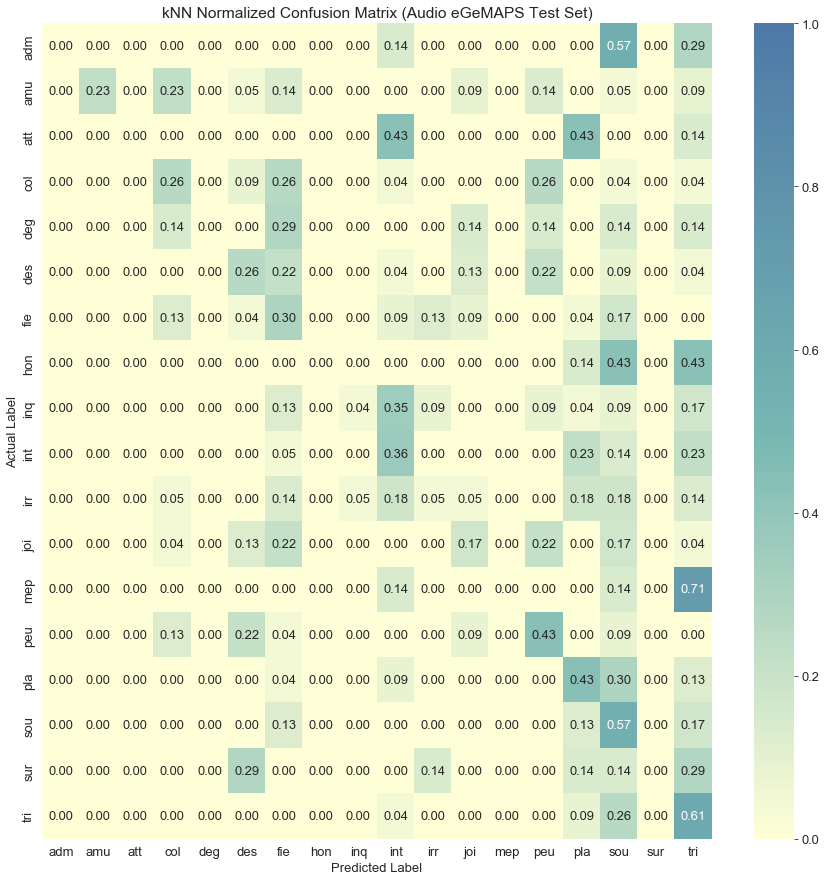

In [18]:
from sklearn.metrics import confusion_matrix


X = test_egemaps_df.drop(columns=['target'])
y = test_egemaps_df['target']

# Get test features and labels from the dataset
X_array =  min_max_scaler_egemaps.transform(X)
X_test_db = pd.DataFrame(data=X_array, columns=X.columns.to_list())
y_test_db = y

# load the model from disk
file_path = os.path.join(output_path,'models','mod_knn_egemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'kNN Normalized Confusion Matrix (Audio eGeMAPS Test Set)',
                      file_name = 'conf_mat_knn_egemaps_audio.svg'
                     )

### GeMAPS

In [16]:
from sklearn.neighbors import KNeighborsClassifier


# Create new variables to split the train dataset into k folds
X = X_scaled_gemaps_df
y = y_gemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
n_neigh_values   = np.arange(50, 405, 5).tolist()
leaf_size_values = np.arange(30, 310, 5).tolist()
weights_values   = ['uniform', 'distance']
parameters = [(n_neigh,leaf_size,weights)  
              for n_neigh in n_neigh_values
              for leaf_size in leaf_size_values
              for weights in weights_values
             ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y): 
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Create a new classifier and fit it (train dataset)
        clf = KNeighborsClassifier(n_neighbors  = parameters[i][0],
                                   leaf_size    = parameters[i][1],
                                   weights      = parameters[i][2],
                                   n_jobs       = -1
                                  )
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)             # Predict probability
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC score
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_neighbors
                    parameters[i][1],                 # leaf_size
                    parameters[i][2],                 # weights
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                  # Update best average AUC
        params_best_model = parameters[i]             # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['k_neighbors','leaf_size','weights','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_folds)+'_fold_cv_gemaps_audio.csv') , index=None, header=True)



# Train model with the parameters of the best model  (using full training set)    
best_model = KNeighborsClassifier(n_neighbors  = params_best_model[0],
                                  leaf_size    = params_best_model[1],
                                  weights      = params_best_model[2],
                                  n_jobs       = -1
                                 )
best_model.fit(X_scaled_gemaps_df, y_gemaps_df)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_gemaps_audio.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 7952/7952 [3:04:43<00:00,  1.39s/it]  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=60, p=2,
                     weights='distance')


In [17]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,k_neighbors,leaf_size,weights,AUC_avg
251,60,95,distance,0.802581
253,60,100,distance,0.802581
279,60,165,distance,0.802581
277,60,160,distance,0.802581
275,60,155,distance,0.802581


AUC (test): 0.8212234372207642


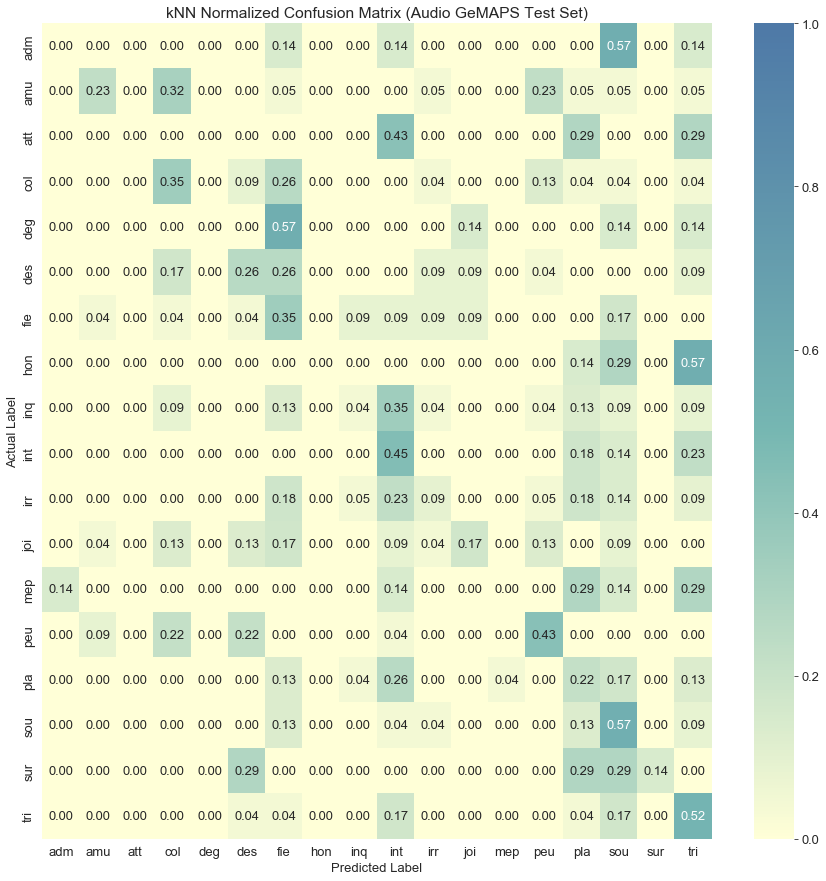

In [19]:
from sklearn.metrics import confusion_matrix


X = test_gemaps_df.drop(columns=['target'])
y = test_gemaps_df['target']

# Get test features and labels from the dataset
X_array =  min_max_scaler_gemaps.transform(X)
X_test_db = pd.DataFrame(data=X_array, columns=X.columns.to_list())
y_test_db = y

# load the model from disk
file_path = os.path.join(output_path,'models','mod_knn_gemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'kNN Normalized Confusion Matrix (Audio GeMAPS Test Set)',
                      file_name = 'conf_mat_knn_gemaps_audio.svg'
                     )

## Decision Tree

### eGeMAPS

In [19]:
from sklearn.tree import DecisionTreeClassifier


# Create new variables to split the train dataset into k folds
X = X_scaled_egemaps_df
y = y_egemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters = [(criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features)  
              for criterion in criterion_values
              for splitter in splitter_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for max_features in max_features_values
             ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Create a new classifier and fit it (train dataset)
        clf = DecisionTreeClassifier(criterion         = parameters[i][0],
                                     splitter          = parameters[i][1],
                                     max_depth         = parameters[i][2],
                                     min_samples_split = parameters[i][3],
                                     min_samples_leaf  = parameters[i][4],
                                     max_features      = parameters[i][5],
                                     random_state      = seed,
                                     class_weight      = class_weight
                                  )
        clf.fit(X_train,y_train)
        

        scores = clf.predict_proba(X_val)             # Predict probabilities
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # criterion
                    parameters[i][1],                 # splitter
                    parameters[i][2],                 # max_depth
                    parameters[i][3],                 # min_samples_split
                    parameters[i][4],                 # min_samples_leaf
                    parameters[i][5],                 # max_features
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['criterion','splitter','max_depth','min_samples_split','min_samples_leaf','max_features','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_folds)+'_fold_cv_egemaps_audio.csv') , index=None, header=True)


# Train model with the parameters of the best model
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_egemaps_df), y=y_egemaps_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = DecisionTreeClassifier(criterion         = params_best_model[0],
                                    splitter          = params_best_model[1],
                                    max_depth         = params_best_model[2],
                                    min_samples_split = params_best_model[3],
                                    min_samples_leaf  = params_best_model[4],
                                    max_features      = params_best_model[5],
                                    random_state      = seed,
                                    class_weight      = class_weight
                                  )
best_model.fit(X_scaled_egemaps_df, y_egemaps_df)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_egemaps_audio.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 36000/36000 [7:06:47<00:00,  1.41it/s]  


DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.7827529021558872,
                                     14: 0.7827529021558872,
                                     15: 0.78275290215588

In [20]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features,AUC_avg
20711,entropy,best,20,0.1,0.1,57,0.72961
19901,entropy,best,15,0.2,0.1,57,0.72961
26201,entropy,best,50,0.2,0.1,57,0.72961
26111,entropy,best,50,0.1,0.1,57,0.72961
20801,entropy,best,20,0.2,0.1,57,0.72961


AUC (test): 0.7175150962289335


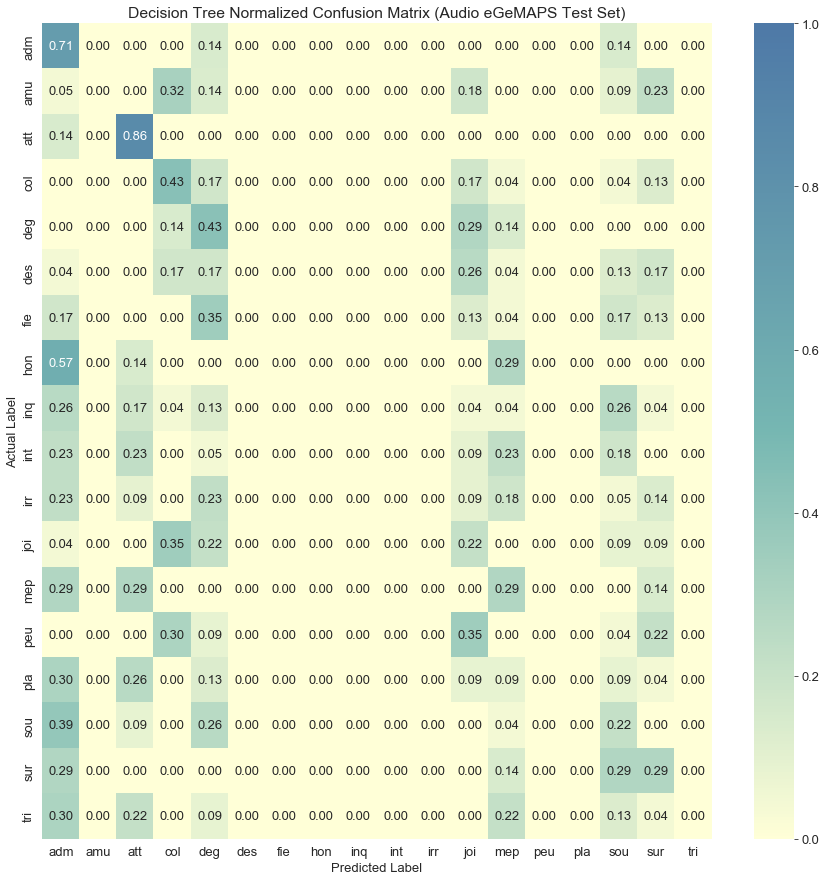

In [20]:
from sklearn.metrics import confusion_matrix


X = test_egemaps_df.drop(columns=['target'])
y = test_egemaps_df['target']

# Get test features and labels from the dataset
X_array =  min_max_scaler_egemaps.transform(X)
X_test_db = pd.DataFrame(data=X_array, columns=X.columns.to_list())
y_test_db = y

# load the model from disk
file_path = os.path.join(output_path,'models','mod_tree_egemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Decision Tree Normalized Confusion Matrix (Audio eGeMAPS Test Set)',
                      file_name = 'conf_mat_tree_egemaps_audio.svg'
                     )

### GeMAPS

In [22]:
from sklearn.tree import DecisionTreeClassifier


# Create new variables to split the train dataset into k folds
X = X_scaled_gemaps_df
y = y_gemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters = [(criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features)  
              for criterion in criterion_values
              for splitter in splitter_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for max_features in max_features_values
             ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Create a new classifier and fit it (train dataset)
        clf = DecisionTreeClassifier(criterion         = parameters[i][0],
                                     splitter          = parameters[i][1],
                                     max_depth         = parameters[i][2],
                                     min_samples_split = parameters[i][3],
                                     min_samples_leaf  = parameters[i][4],
                                     max_features      = parameters[i][5],
                                     random_state      = seed,
                                     class_weight      = class_weight
                                  )
        clf.fit(X_train,y_train)
        

        scores = clf.predict_proba(X_val)             # Predict probabilities
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # criterion
                    parameters[i][1],                 # splitter
                    parameters[i][2],                 # max_depth
                    parameters[i][3],                 # min_samples_split
                    parameters[i][4],                 # min_samples_leaf
                    parameters[i][5],                 # max_features
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['criterion','splitter','max_depth','min_samples_split','min_samples_leaf','max_features','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_folds)+'_fold_cv_gemaps_audio.csv') , index=None, header=True)


# Train model with the parameters of the best model
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_gemaps_df), y=y_gemaps_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = DecisionTreeClassifier(criterion         = params_best_model[0],
                                    splitter          = params_best_model[1],
                                    max_depth         = params_best_model[2],
                                    min_samples_split = params_best_model[3],
                                    min_samples_leaf  = params_best_model[4],
                                    max_features      = params_best_model[5],
                                    random_state      = seed,
                                    class_weight      = class_weight
                                  )
best_model.fit(X_scaled_gemaps_df, y_gemaps_df)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_gemaps_audio.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 36000/36000 [9:14:40<00:00,  1.08it/s]   


DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.7827529021558872,
                                     14: 0.7827529021558872,
                                     15: 0.78275290215588

In [23]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features,AUC_avg
25297,entropy,best,45,0.2,0.1,26,0.714112
22597,entropy,best,30,0.2,0.1,26,0.714112
19807,entropy,best,15,0.1,0.1,26,0.714112
23407,entropy,best,35,0.1,0.1,26,0.714112
26197,entropy,best,50,0.2,0.1,26,0.714112


AUC (test): 0.7198326973568829


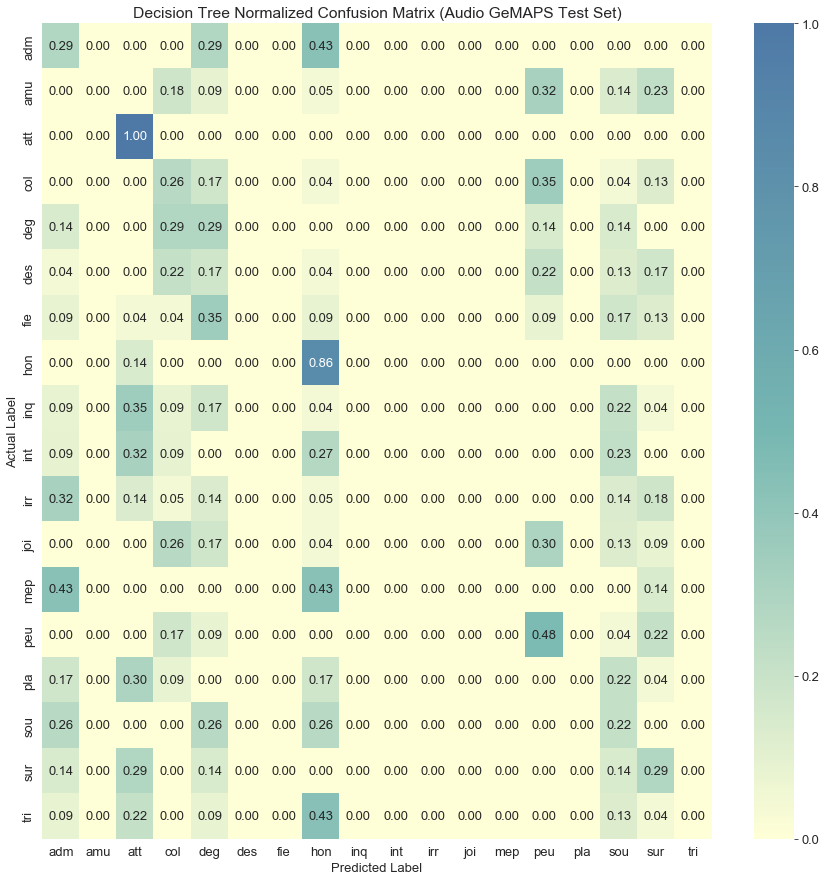

In [21]:
from sklearn.metrics import confusion_matrix


X = test_gemaps_df.drop(columns=['target'])
y = test_gemaps_df['target']

# Get test features and labels from the dataset
X_array =  min_max_scaler_gemaps.transform(X)
X_test_db = pd.DataFrame(data=X_array, columns=X.columns.to_list())
y_test_db = y

# load the model from disk
file_path = os.path.join(output_path,'models','mod_tree_gemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Decision Tree Normalized Confusion Matrix (Audio GeMAPS Test Set)',
                      file_name = 'conf_mat_tree_gemaps_audio.svg'
                     )

## Random Forest

### eGeMAPS

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


# Create new variables to split the train dataset into k folds
X = X_scaled_egemaps_df
y = y_egemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters = [(n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap)  
              for n_estimators in n_estimators_values
              for criterion in criterion_values
              for max_features in max_features_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for bootstrap in bootstrap_values
             ]
#print(len(parameters))

# Randomized Search CV (we need randomize search beacuse there are a lot of combinations)
parameters = resample(parameters, n_samples=5000, replace=False, random_state=seed)


# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    clf = RandomForestClassifier(n_estimators      = parameters[i][0],
                                 criterion         = parameters[i][1],
                                 max_features      = parameters[i][2],
                                 max_depth         = parameters[i][3],
                                 min_samples_split = parameters[i][4],
                                 min_samples_leaf  = parameters[i][5],
                                 bootstrap         = parameters[i][6],
                                 random_state      = seed,
                                 n_jobs            = -1
                                )
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y): 
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Modify classifier class weight and fit the model (train dataset)
        clf.class_weight = class_weight
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)             # Predict probability
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC score
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_estimators
                    parameters[i][1],                 # criterion
                    parameters[i][2],                 # max_features
                    parameters[i][3],                 # max_depth
                    parameters[i][4],                 # min_samples_split
                    parameters[i][5],                 # min_samples_leaf
                    parameters[i][6],                 # bootstrap
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                  # Update best average AUC
        params_best_model = parameters[i]             # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['n_estimators','criterion','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_folds)+'_fold_cv_egemaps_audio.csv') , index=None, header=True)



# Train model with the parameters of the best model
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_egemaps_df), y=y_egemaps_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = RandomForestClassifier(n_estimators      = params_best_model[0],
                                    criterion         = params_best_model[1],
                                    max_features      = params_best_model[2],
                                    max_depth         = params_best_model[3],
                                    min_samples_split = params_best_model[4],
                                    min_samples_leaf  = params_best_model[5],
                                    bootstrap         = params_best_model[6],
                                    class_weight      = class_weight,
                                    random_state      = seed,
                                    n_jobs            = -1
                                   )
best_model.fit(X_scaled_egemaps_df, y_egemaps_df)    # Fit model

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_egemaps_audio.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 5000/5000 [8:24:41<00:00,  6.06s/it]   


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.78...
                                     15: 0.7827529021558872,
                                     16: 2.280193236

In [26]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,n_estimators,criterion,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap,AUC_avg
4536,410,gini,auto,20.0,2,2,False,0.862856
2036,410,gini,auto,40.0,2,2,False,0.862849
1930,410,gini,auto,100.0,2,2,False,0.862849
911,410,gini,sqrt,60.0,2,2,False,0.862849
1099,410,gini,auto,30.0,2,2,False,0.862849


AUC (test): 0.8943715440734769


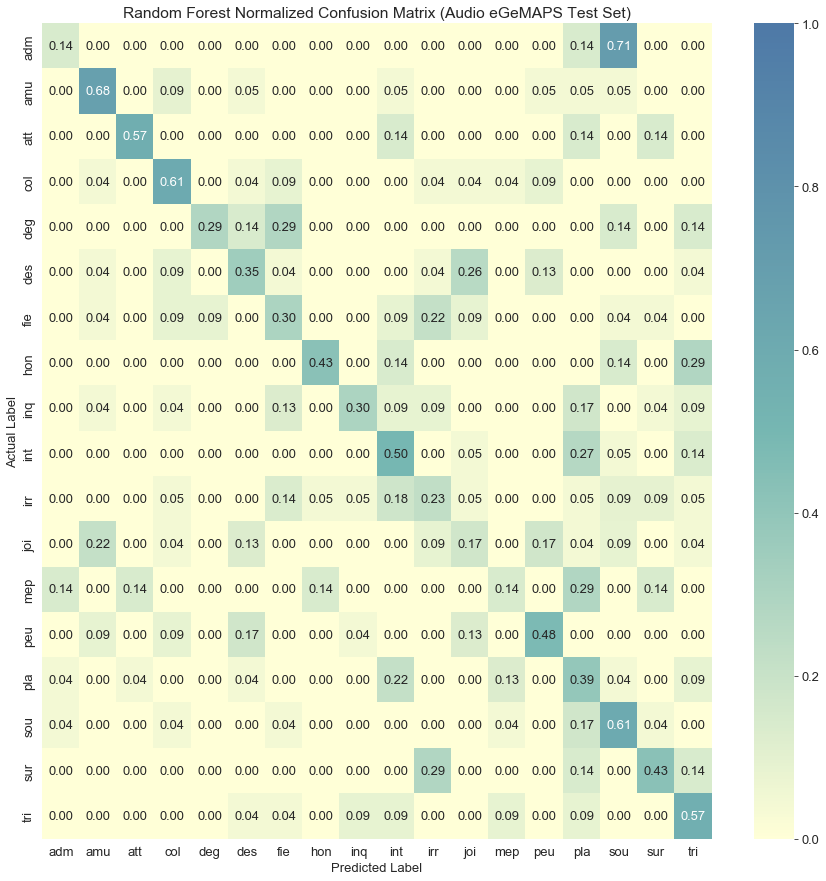

In [22]:
from sklearn.metrics import confusion_matrix


X = test_egemaps_df.drop(columns=['target'])
y = test_egemaps_df['target']

# Get test features and labels from the dataset
X_array =  min_max_scaler_egemaps.transform(X)
X_test_db = pd.DataFrame(data=X_array, columns=X.columns.to_list())
y_test_db = y

# load the model from disk
file_path = os.path.join(output_path,'models','mod_rf_egemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Random Forest Normalized Confusion Matrix (Audio eGeMAPS Test Set)',
                      file_name = 'conf_mat_rf_egemaps_audio.svg',
                      report    = True
                     )

### GeMAPS

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


# Create new variables to split the train dataset into k folds
X = X_scaled_gemaps_df
y = y_gemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters = [(n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap)  
              for n_estimators in n_estimators_values
              for criterion in criterion_values
              for max_features in max_features_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for bootstrap in bootstrap_values
             ]
#print(len(parameters))

# Randomized Search CV (we need randomize search beacuse there are a lot of combinations)
parameters = resample(parameters, n_samples=5000, replace=False, random_state=seed)


# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    clf = RandomForestClassifier(n_estimators      = parameters[i][0],
                                 criterion         = parameters[i][1],
                                 max_features      = parameters[i][2],
                                 max_depth         = parameters[i][3],
                                 min_samples_split = parameters[i][4],
                                 min_samples_leaf  = parameters[i][5],
                                 bootstrap         = parameters[i][6],
                                 random_state      = seed,
                                 n_jobs            = -1
                                )
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y): 
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Modify classifier class weight and fit the model (train dataset)
        clf.class_weight = class_weight
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)             # Predict probability
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC score
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_estimators
                    parameters[i][1],                 # criterion
                    parameters[i][2],                 # max_features
                    parameters[i][3],                 # max_depth
                    parameters[i][4],                 # min_samples_split
                    parameters[i][5],                 # min_samples_leaf
                    parameters[i][6],                 # bootstrap
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                  # Update best average AUC
        params_best_model = parameters[i]             # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['n_estimators','criterion','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_folds)+'_fold_cv_gemaps_audio.csv') , index=None, header=True)



# Train model with the parameters of the best model
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_gemaps_df), y=y_gemaps_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = RandomForestClassifier(n_estimators      = params_best_model[0],
                                    criterion         = params_best_model[1],
                                    max_features      = params_best_model[2],
                                    max_depth         = params_best_model[3],
                                    min_samples_split = params_best_model[4],
                                    min_samples_leaf  = params_best_model[5],
                                    bootstrap         = params_best_model[6],
                                    class_weight      = class_weight,
                                    random_state      = seed,
                                    n_jobs            = -1
                                   )
best_model.fit(X_scaled_gemaps_df, y_gemaps_df)    # Fit model

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_gemaps_audio.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 5000/5000 [7:15:17<00:00,  5.22s/it]  


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.78...
                                     15: 0.7827529021558872,
                                     16: 2.280193236

In [29]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,n_estimators,criterion,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap,AUC_avg
3530,415,gini,auto,20.0,5,1,False,0.854206
4703,475,gini,sqrt,110.0,5,1,False,0.854044
3727,475,gini,auto,50.0,5,1,False,0.854044
1997,470,gini,sqrt,80.0,5,1,False,0.854002
2441,470,gini,sqrt,70.0,5,1,False,0.854002


AUC (test): 0.8769916258045554


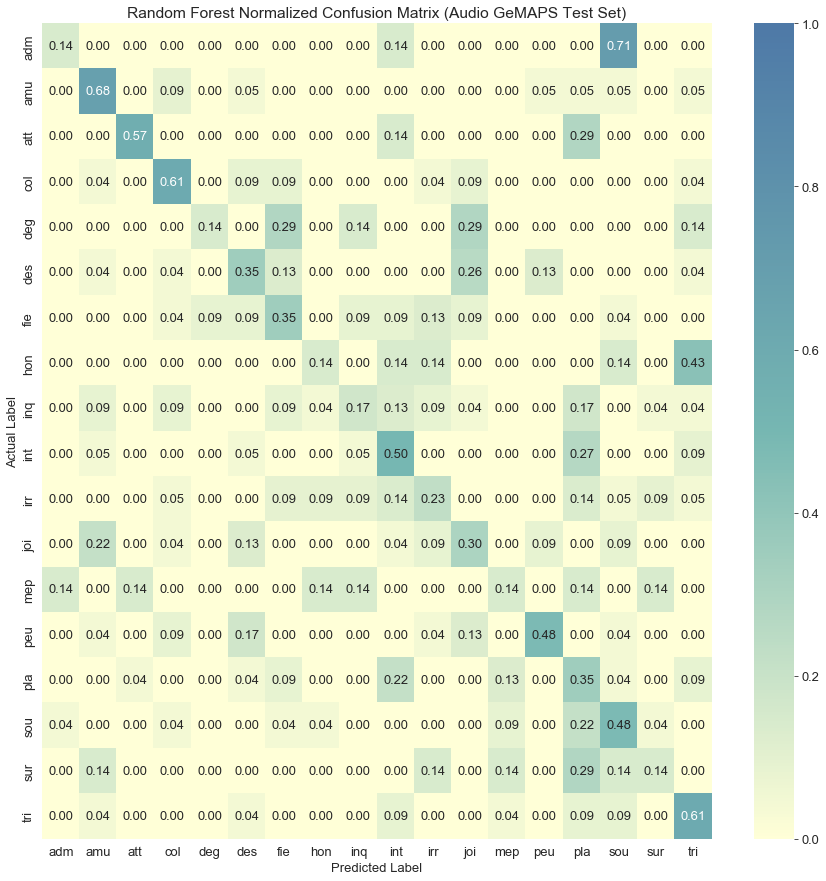

In [23]:
from sklearn.metrics import confusion_matrix


X = test_gemaps_df.drop(columns=['target'])
y = test_gemaps_df['target']

# Get test features and labels from the dataset
X_array =  min_max_scaler_gemaps.transform(X)
X_test_db = pd.DataFrame(data=X_array, columns=X.columns.to_list())
y_test_db = y

# load the model from disk
file_path = os.path.join(output_path,'models','mod_rf_gemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Random Forest Normalized Confusion Matrix (Audio GeMAPS Test Set)',
                      file_name = 'conf_mat_rf_gemaps_audio.svg',
                      report    = False
                     )

## BEST MODEL VALIDATION CONFUSION MATRIX

AUC_avg (validation): 0.8628558362200895


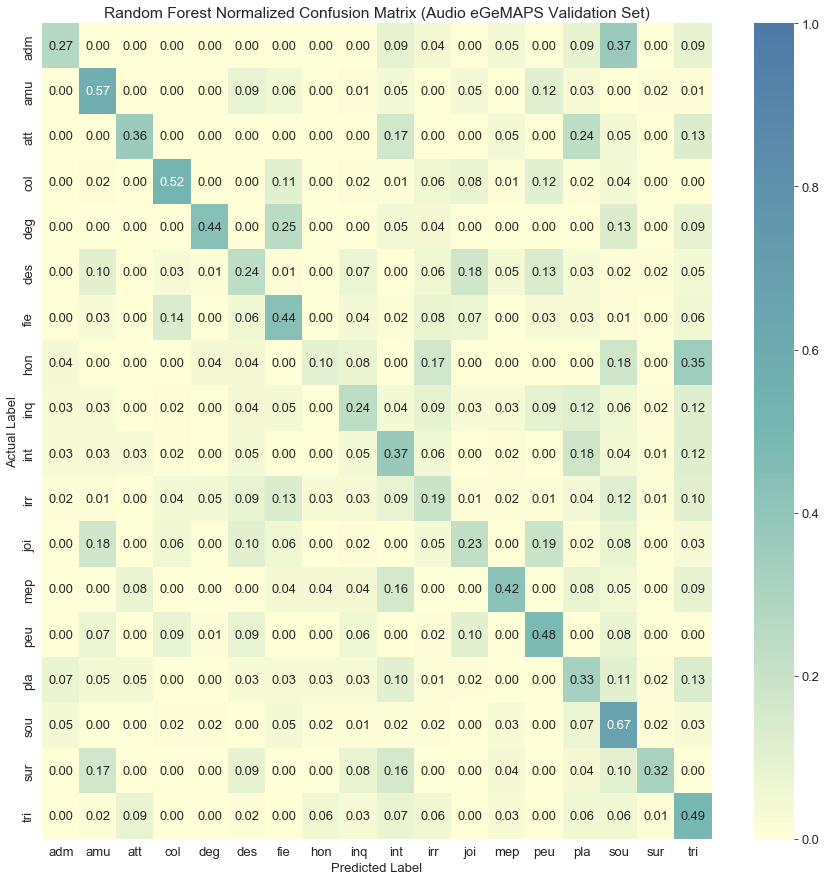

In [25]:
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(n_estimators      = 410,            # Create audio model with best parameters
                             criterion         = 'gini',
                             max_features      = 'auto',
                             max_depth         = 20,
                             min_samples_split = 2,
                             min_samples_leaf  = 2,
                             bootstrap         = False,
                             random_state      = seed,
                             n_jobs            = -1
                        ) 


# Create new variables to split the train dataset into k folds
X = X_scaled_egemaps_df
y = y_egemaps_df
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)



# Initialize some variables to store results
results = []
AUC_avg = 0 # Initialize average AUC
conf_mat_avg = np.zeros([18,18])
for train_idx, val_idx in skf.split(X, y): 
    X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
    
    # Compute class weight
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight = {n:class_weight[n] for n in range(0,18)}
    
    # Modify classifier class weight and fit the model (train dataset)
    clf.class_weight = class_weight
    clf.fit(X_train,y_train)
    
    # Compute results (validation dataset)
    scores = clf.predict_proba(X_val)                 # Predict probability
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='macro',
                            multi_class='ovo')        # Get AUC score
    AUC_avg += AUC_tmp                                # Add new AUC score
    
    y_pred = clf.predict(X_val)                       # Predict class
    conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                   )
    conf_mat_avg += conf_mat_tmp

AUC_avg /= n_folds                                    # Get average AUC for alpha = a
print('AUC_avg (validation):',AUC_avg)
conf_mat_avg /= n_folds


df_cm = pd.DataFrame(conf_mat_avg, list(emotion_id_to_emotion_num.keys()), list(emotion_id_to_emotion_num.keys()))

plt.figure(figsize=(15,15))
ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
plt.yticks(va='center')
plt.title('Random Forest Normalized Confusion Matrix (Audio eGeMAPS Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.savefig(os.path.join(output_path,'confusion_matrix','conf_mat_rf_egemaps_audio_validation.svg'), bbox_inches = 'tight')
#plt.show()